### An unsupervised deep learning method for rock properties estimation
#### Runhai Feng
####  [GoogleScholar](https://scholar.google.nl/citations?user=Lu1PcXwAAAAJ&hl=en)|[GitHub](https://github.com/RhFeng)


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

Set the directory

In [2]:
osdir = os.getcwd()

In [3]:
Vp_t = np.loadtxt('Vp_t.dat')
Vs_t = np.loadtxt('Vs_t.dat')
Den_t = np.loadtxt('Den_t.dat')

Vp0_t = np.loadtxt('Vp0_t.dat')
Vs0_t = np.loadtxt('Vs0_t.dat')
Den0_t = np.loadtxt('Den0_t.dat')

Vp_t = np.float32(np.reshape(Vp_t,(-1,1)))
Vs_t = np.float32(np.reshape(Vs_t,(-1,1)))
Den_t = np.float32(np.reshape(Den_t,(-1,1)))

Vp0_t = np.float32(np.reshape(Vp0_t,(-1,1)))
Vs0_t = np.float32(np.reshape(Vs0_t,(-1,1)))
Den0_t = np.float32(np.reshape(Den0_t,(-1,1)))

In [4]:
dt = 0.004
nt = len(Vp_t)
T = dt * np.linspace(0.0, nt - 1, num = nt)

Define the incident angles

In [5]:
# incidence angle
theta1_num = 15
theta1_step= 4.0
angle = theta1_step * np.linspace(0, theta1_num-1, theta1_num)
angle = np.float32(np.reshape(angle, (-1,1)))
nangles = len(angle)

In [6]:
#ricker wavelet
from ricker import ricker

wvlt_length= (nt - 1) * dt # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_cfreq = 60.0  # Ricker wavelet central frequency


wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

# create the wavelet map
wvlt_map = np.zeros((len(wvlt_t),len(wvlt_t)))

half = int(nt/2)

for i in range(half):
    wvlt_map[0:len(wvlt_t)+i-(half)+1,i] = wvlt_amp[(half)-i-1:]
    
for i in range(half,len(wvlt_t)):
    wvlt_map[i-len(wvlt_t)+half:,i] = wvlt_amp[0:len(wvlt_t)-i+half-1]

from simulate_zoep_np import simulate_np

ref_t = simulate_np(Vp_t, Vs_t, Den_t, angle)

ref_t = np.transpose(ref_t)

PP_t = np.matmul(wvlt_map, ref_t)

PP_plus = np.zeros((1,nangles))

PP_t = np.vstack((PP_plus, PP_t)) 

In [7]:
# add noise to seismic
Noise = 1
SNR = 30

if Noise == 1:
    for i in range(PP_t.shape[1]):
        SignalRMS = np.sqrt(np.mean(np.power(PP_t[:, i], 2)))
        NoiseTD   = np.random.randn(len(PP_t[:, i]),1)
        NoiseRMS  = np.sqrt(np.mean(np.power(NoiseTD, 2)));
        New = np.reshape(PP_t[:, i], (-1, 1)) + (SignalRMS/NoiseRMS) * np.power(10, -SNR/20) * NoiseTD
        PP_t[:, i] = New[:, 0]

In [8]:
# expand the signal
X_train_init = PP_t #np.reshape(PP_t[:,0],[-1,1])
Y_train = PP_t[1:,:] #np.reshape(PP_t[1:,0],[-1,1])  #Vp_Vs_den

window_width = 10

from expand_dims import expand_dims

X_train = expand_dims(X_train_init, window_width)  

In [9]:
#%% Define the cnn model
Vp_t_tf = tf.constant(Vp_t, dtype=tf.float32, name='Vp_t_tf')
Vs_t_tf = tf.constant(Vs_t, dtype=tf.float32, name='Vs_t_tf')
Den_t_tf = tf.constant(Den_t, dtype=tf.float32, name='Den_t_tf')

Vp0_t_tf = tf.constant(Vp0_t, dtype=tf.float32, name='Vp0_t_tf')
Vs0_t_tf = tf.constant(Vs0_t, dtype=tf.float32, name='Vs0_t_tf')
Den0_t_tf = tf.constant(Den0_t, dtype=tf.float32, name='Den0_t_tf')

angle_tf = tf.constant(angle, dtype=tf.float32, name='angle_tf')
wvlt_map_tf = tf.constant(wvlt_map, dtype=tf.float32, name='wvlt_map_tf')


# input x and y
input_data   = tf.placeholder(tf.float32, shape = X_train.shape)
output_data  = tf.placeholder(tf.float32, shape = Y_train.shape)

input_dim = 1
num_filters = 12
dropout_prob = 0.5

## neural network layers
conv1       = tf.layers.conv1d(input_data, num_filters, 1, strides=1, padding = 'valid')
conv1_norm  = tf.layers.batch_normalization(conv1)
conv1_activ = tf.nn.sigmoid(conv1_norm)

conv2       = tf.layers.conv1d(conv1_activ, num_filters, 3, padding = 'valid')
conv2_norm  = tf.layers.batch_normalization(conv2)
conv2_activ = tf.nn.sigmoid(conv2_norm)

dropout     = tf.nn.dropout(conv2_activ, keep_prob = 1 - dropout_prob/2)

flat_layer  = tf.layers.flatten(dropout)
dense       = tf.layers.dense(flat_layer, units = 4 * num_filters)
dense_norm  = tf.layers.batch_normalization(dense)
dense_activ = tf.nn.sigmoid(dense_norm)

y_pred      = tf.layers.dense(dense_activ, units = 3)
y_pred      = tf.nn.tanh(y_pred)

Vp_pred      = tf.reshape(y_pred[:,0],[-1,1]) + Vp0_t_tf
Vs_pred      = tf.reshape(y_pred[:,1],[-1,1]) + Vs0_t_tf
Den_pred     = tf.reshape(y_pred[:,2],[-1,1]) + Den0_t_tf

from simulate_zoep import simulate


ref_t_predict = simulate(Vp_pred, Vs_pred, Den_pred, angle_tf)
ref_t_predict = tf.transpose(ref_t_predict)
ref_t_predict = tf.reshape(ref_t_predict,[-1,nangles])

syn_PP_t = tf.matmul(wvlt_map_tf, ref_t_predict)

Y_pred = tf.concat([Vp_pred, Vs_pred, Den_pred], 1)

Y_true = tf.concat([Vp0_t_tf, Vs0_t_tf, Den0_t_tf], 1)

data_misfit = 10 * tf.reduce_mean(tf.square(syn_PP_t - output_data)) 
model_misfit = 0.01 * tf.reduce_mean(tf.square(Y_pred - Y_true))
Vp_misfit    = 0.001 * tf.reduce_mean(tf.square(Vp_pred - Vp0_t_tf))  
Vs_misfit    = 0.004 * tf.reduce_mean(tf.square(Vs_pred - Vs0_t_tf))  
Den_misfit    = 0.01 * tf.reduce_mean(tf.square(Den_pred - Den0_t_tf)) 

up = tf.reduce_mean(tf.square(Y_pred[0,:] - Y_true[0,:]))
bottom = tf.reduce_mean(tf.square(Y_pred[-1,:] - Y_true[-1,:]))

loss = data_misfit + 1 * (up + bottom) / 2
optimizer = tf.train. AdamOptimizer(0.01)

train = optimizer.minimize(loss)

Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# now do the training
iter = 5001

l = np.zeros((iter,1))
data_error = np.zeros((iter,1))
model_error = np.zeros((iter,1))
Vp_pred = np.zeros((nt,1))
Vs_pred = np.zeros((nt,1))
Den_pred = np.zeros((nt,1))

with tf.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
        
    for step in range(iter):
        dic = {input_data: X_train, output_data: Y_train}
        
        _, Prediction, l[step], _ = sess.run([train, Y_pred, loss, y_pred], feed_dict = dic)
        
        Vp_pred  = np.reshape(Prediction[:,0],[-1,1]).ravel() 
        Vs_pred  = np.reshape(Prediction[:,1],[-1,1]).ravel() 
        Den_pred = np.reshape(Prediction[:,2],[-1,1]).ravel() 
        
        if step % 1000 == 0:
            print('step {}'.format(step))
            print(l[step])

step 0
[0.6958524]
step 1000
[0.00203288]
step 2000
[0.0016773]
step 3000
[0.00096081]
step 4000
[0.00090229]
step 5000
[0.00057608]


/Users/Runhai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


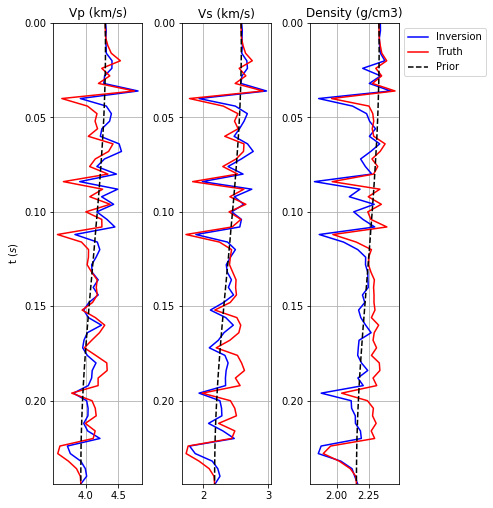

In [11]:
# plot the result
fig = plt.figure(num = 8, figsize=(8, 8))
fig.set_facecolor('white')
plt.subplot(131)
plt.plot(Vp_pred.ravel(), T, '-b', label = 'Inversion')
plt.plot(Vp_t.ravel(), T, '-r', label = 'Truth')
plt.plot(Vp0_t.ravel(), T, '--k', label = 'Prior')
plt.ylim(T[0],T[-1])
plt.gca().invert_yaxis()
plt.title('Vp (km/s)')
plt.grid(True)
plt.ylabel('t ($s$)')
    
plt.subplot(132)
plt.plot(Vs_pred.ravel(), T, '-b', label = 'Inversion')
plt.plot(Vs_t.ravel(), T, '-r', label = 'Truth')
plt.plot(Vs0_t.ravel(), T, '--k', label = 'Prior')
plt.ylim(T[0],T[-1])
plt.gca().invert_yaxis()
plt.title('Vs (km/s)')
plt.grid(True)
    
plt.subplot(133)
plt.plot(Den_pred.ravel(), T, '-b', label = 'Inversion')
plt.plot(Den_t.ravel(), T, '-r', label = 'Truth')
plt.plot(Den0_t.ravel(), T, '--k', label = 'Prior')
plt.ylim(T[0],T[-1])
plt.gca().invert_yaxis()
plt.title('Density (g/cm3)')
plt.grid(True)
    
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)
plt.subplots_adjust(wspace = 0.45, hspace =0)
ax = plt.subplot(133)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*1, box.height])
legend_x = 1
legend_y = 1
plt.legend(loc='upper left', bbox_to_anchor=(legend_x, legend_y))
plt.pause(0.000001)

### Comments
In this demo, convolutional neural networks is used to estimate rock properties (Vp, Vs and bulk density) in an unsupervised manner. Zoeppritz equations (Aki and Richards, 2002) is applied to calculate the reflection coefficients.

## Reference

Feng, R. 2020. Unsupervised learning elastic rock properties from pre-stack seismic data. Journal of Petroleum Science & Engineering. Accepted.